## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([mirna_tumor, mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = mirna_tumor.shape[0]
n_normal = mirna_normal.shape[0]

# Drop categorical columns
mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(gene_exp_tumor.columns, return_index=True)
gene_exp_tumor = gene_exp_tumor.iloc[:, i]
gene_exp_normal = gene_exp_normal.iloc[:, i]

print "mirna_tumor", mirna_tumor.shape, 'nulls:', mirna_tumor.isnull().sum().sum()
print "gene_exp_tumor", gene_exp_tumor.shape, 'nulls:', gene_exp_tumor.isnull().sum().sum()
print "mirna_normal", mirna_normal.shape, 'nulls:', mirna_normal.isnull().sum().sum()
print "gene_exp_normal", gene_exp_normal.shape, 'nulls:', gene_exp_normal.isnull().sum().sum()

NaN            7
Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


mirna_tumor (503, 1881) nulls: 0
gene_exp_tumor (503, 20484) nulls: 0
mirna_normal (20, 1881) nulls: 0
gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [7]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

NameError: name 'mirna_new' is not defined

## Loading TargetScan database for predicted miRNA-targets interactions

In [6]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs

In [7]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(dys_threshold=0.6)
network.train(miRNAs_tumor=mirna_tumor, targets_tumor=gene_exp_tumor,
              miRNAs_normal=mirna_normal, targets_normal=gene_exp_normal,
              putative_assocs=targetScan_df)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


src/models/miRNA_target_network.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNAs_normal[m]) * np.std(targets_normal[t]))


src/models/miRNA_target_network.py:44: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNAs_tumor[m]) * np.std(targets_tumor[t]))


In [257]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

1881
20484
edges 2301


## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [268]:
network.get_miRNA_groups(mirna_list, larger_groups=True);

### Map labels for classification task

In [104]:
pathologic_stage_map = {'normal': -1,'Stage I': 1, 'Stage IA': 1, 'Stage IB': 1,
                        'Stage II': 1, 'Stage IIA': 1, 'Stage IIB': 1,
                        'Stage III': 1, 'Stage IIIA': 1, 'Stage IIIB': 1,
                        'Stage IV': 1}
y = Y.replace(pathologic_stage_map)
y

0      1
1      1
2      1
3      1
4      1
5      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
30     1
      ..
502    1
503    1
505    1
506    1
507    1
508    1
509    1
510    1
511    1
512    1
0     -1
3     -1
6     -1
8     -1
9     -1
13    -1
14    -1
16    -1
21    -1
22    -1
23    -1
27    -1
30    -1
32    -1
34    -1
35    -1
38    -1
39    -1
40    -1
41    -1
Name: pathologic_stage, dtype: int64

## Create Classifiers

In [315]:
from sklearn.model_selection import train_test_split
from src.models.group_lasso_spams import SPAMSClassifier

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'lambda1': 0.05, 'it0': 10, 'max_it': 300,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['loss'] = 'weighted-logistic'
param['regul'] = 'group-lasso-l2'
param['lambda1'] = 0.5

X = np.asanyarray(pandas.concat([mirna_tumor, mirna_normal]), dtype=myfloat)
y = np.array(y, dtype=myfloat)
y = np.reshape(y, [y.shape[0], 1])

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.3, random_state=np.random.randint(0, 10000), stratify=y)

X_train = np.asfortranarray(X_train)

print "X_train", X_train.shape
print "Y_train", Y_train.shape, np.unique(Y_train)

group_l2 = SPAMSClassifier()
group_l2.fit(X_train, Y_train, groups=np.array(network.get_miRNA_groups(mirna_list), dtype=np.int32), params=param)

group_l2_large_groups = SPAMSClassifier()
group_l2_large_groups.fit(X_train, Y_train, 
                          groups=np.array(network.get_miRNA_groups(mirna_list, larger_groups=False), dtype=np.int32),
                          params=param)

group_wo_groups = SPAMSClassifier()
group_wo_groups.fit(X_train, Y_train, groups=np.array(np.arange(1881)+1, dtype=np.int32), params=param)

param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=np.array(np.arange(1881)+1, dtype=np.int32), params=param)

param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=np.array(network.get_miRNA_groups(mirna_list), dtype=np.int32), params=param)

param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=np.array(network.get_miRNA_groups(mirna_list), dtype=np.int32), params=param)

X_train (366, 1881)
Y_train (366, 1) [-1.  1.]


group-lasso-l2
non-zero 139
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         8
     Stages       1.00      1.00      1.00       202

avg / total       1.00      1.00      1.00       210


Without Groups (l1)
non-zero 128
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         8
     Stages       1.00      1.00      1.00       202

avg / total       1.00      1.00      1.00       210


elastic_net
non-zero 128
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         8
     Stages       1.00      1.00      1.00       202

avg / total       1.00      1.00      1.00       210


sparse-group-lasso-l2
non-zero 139
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         8
     Stages       1.00      1.00      1.00       202

avg / total       1.00      1.00      1.00       210



src/models/group_lasso_spams.py:33: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  


## Classification Report

In [311]:
from sklearn import metrics

for model, name in [(group_l2, 'group-lasso-l2'),
                    (group_l2_large_groups, 'group_l2_large_groups'),
                    (group_wo_groups, 'Without Groups (l1)'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group-lasso-l2')]:
    print '\n', name
    print 'non-zero', model.get_selected_miRNAs(mirna_list).shape[0]

    # print metrics.classification_report(Y_train, model.predict(X_train),
    #                                 labels=[-1, 1],
    #                                 target_names=['normal', 'Stages'])

    print metrics.classification_report(Y_test, model.predict(X_test),
                                    labels=[-1, 1],
                                    target_names=['normal', 'Stages'])


group-lasso-l2
non-zero 398
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         6
     Stages       1.00      1.00      1.00       151

avg / total       1.00      1.00      1.00       157


group_l2_large_groups
non-zero 393
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         6
     Stages       1.00      1.00      1.00       151

avg / total       1.00      1.00      1.00       157


Without Groups (l1)
non-zero 386
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         6
     Stages       1.00      1.00      1.00       151

avg / total       1.00      1.00      1.00       157


elastic_net
non-zero 386
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         6
     Stages       1.00      1.00      1.00       151

avg / total       1.00      1.00      1.00       157


sparse-group-l

In [312]:
model.get_selected_miRNAs(mirna_list).head(15)

,miRNA,coef
127,hsa-mir-21,0.000078
63,hsa-mir-143,-0.000036
3,hsa-let-7b,-0.000023
68,hsa-mir-148a,0.000022
137,hsa-mir-22,0.000019
397,hsa-mir-99b,-0.000019
218,hsa-mir-375,0.000013
88,hsa-mir-182,0.000011
164,hsa-mir-30a,-0.000010
120,hsa-mir-203a,0.000008


## Loading HMDD database for experimentally validated NSCLC miRNA

In [313]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()

miRCancer_luad_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(validated_miRNA_csv['miRNA'].tolist())

## Compare models by recall rate

In [314]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate
    
pandas.DataFrame([[name, 
                   model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0], 
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
                              validated_miRNAs=HMDD_lung_neoplasm_miRNAs), 
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
                              validated_miRNAs=HMDD_lung_neoplasm_miRNAs) ] \
                    for model, name in [(group_l2, 'group-lasso-l2'),
                        (group_l2_large_groups, 'group_l2_large_groups'),
                        (group_wo_groups, 'Without Groups (l1)'),
                        (elastic_net, 'elastic_net'),
                        (sparse_group_l2, 'sparse-group-lasso-l2')]], columns=['method', 'no_selected', 'recall_rate', 'precision_rate'])\
    .sort('recall_rate', ascending=False)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,method,no_selected,recall_rate,precision_rate
0,group-lasso-l2,398,0.796178,0.314070
4,sparse-group-lasso-l2,398,0.796178,0.314070
1,group_l2_large_groups,393,0.789809,0.315522
2,Without Groups (l1),386,0.789809,0.321244
3,elastic_net,386,0.789809,0.321244


## Validate miRNA-target edges

In [212]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

SPPL3 hsa-mir-369


[autoreload of _pytest.assertion failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name util
]
[autoreload of py.test.cmdline failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named cmdline
]


NameError: name 'miRecords_df' is not defined

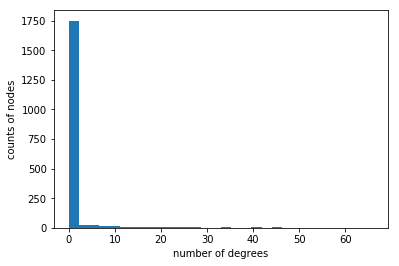

In [114]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()